In [1]:
import sys
sys.path.append('/Users/aartibalana/Documents/transfer-learning/snakeCLEF/training_scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import random
from torchvision import transforms as T
from src.core import models, metrics, training, data, loss_functions
from src.dev import experiments as experiments

DATA_DIR = '../../SnakeCLEF2023-medium_size-train/'
VAL_DIR='../../SnakeCLEF2023-medium_size-val'

# set seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

/Users/aartibalana/Documents/transfer-learning/snakeCLEF/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# load metadata
training_df = pd.read_csv('../../snake_csv_files/SnakeCLEF_bbox_annotations_train_val_rare_diet.csv')
training_df['venom_or_not'] = np.where(training_df['endemic']==True, 1, 0)

training_df.head()
# load metadata
train_df = training_df[:120000]
valid_df = training_df[120000:]

classes = np.unique(train_df['endemic'])
no_classes = len(classes)
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 2
Train set length: 120,000
Validation set length: 25,381


/var/folders/k1/my0k39b95sg30r6_k0vgqk9c0000gn/T/ipykernel_60967/4279631622.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv('../../snake_csv_files/SnakeCLEF_bbox_annotations_train_val_rare_diet.csv')


In [3]:
# create training 
config = experiments.create_config(
    data='clef2023',
    model='efficientnet_b0', #'deit_base_distilled_384'
    loss='ensemble_focal',#'efocal',
    opt='sgd',
    no_epochs=30,
    batch_size=32,
    total_batch_size=32,
    learning_rate=0.001,
    scheduler='reduce_lr_on_plateau',
    
)

# include configuration from model
model_config = models.get_model(config.model, pretrained=True).pretrained_config
config.update(model_config)
model = models.get_model(config.model, no_classes, pretrained=True)

'''
if have already trained model use its weights
'''
# MODEL_ARCH = 'efficientnet_b0'
# MODEL_NAME = 'clef2023_efficientnet_b0_focal_05-04-2023_08-48-38'

# # create model
# model = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
# training.load_model(model, MODEL_NAME, path='.')
# assert np.all([param.requires_grad for param in model.parameters()])
# model_config = model.pretrained_config
# config.update(model_config)

# # save config file
# config.save(config.specs_name)

# create loss, optimizer and scheduler functions
loss_fn = loss_functions.LOSSES[config.loss]

opt_fn = training.OPTIMIZERS[config.opt]
sched_fn = training.SCHEDULERS[config.scheduler]
print(config)

Config(
* model_name: clef2023_efficientnet_b0_ensemble_focal_05-21-2023_23-59-14
* history_file: clef2023_efficientnet_b0_ensemble_focal_05-21-2023_23-59-14.csv
* specs_name: clef2023_efficientnet_b0_ensemble_focal_05-21-2023_23-59-14.json
* model: efficientnet_b0
* loss: ensemble_focal
* opt: sgd
* no_epochs: 30
* batch_size: 32
* total_batch_size: 32
* learning_rate: 0.001
* scheduler: reduce_lr_on_plateau
* pretrained_checkpoint: tf_efficientnet_b0
* input_size: 224
* image_mean: (0.485, 0.456, 0.406)
* image_std: (0.229, 0.224, 0.225))


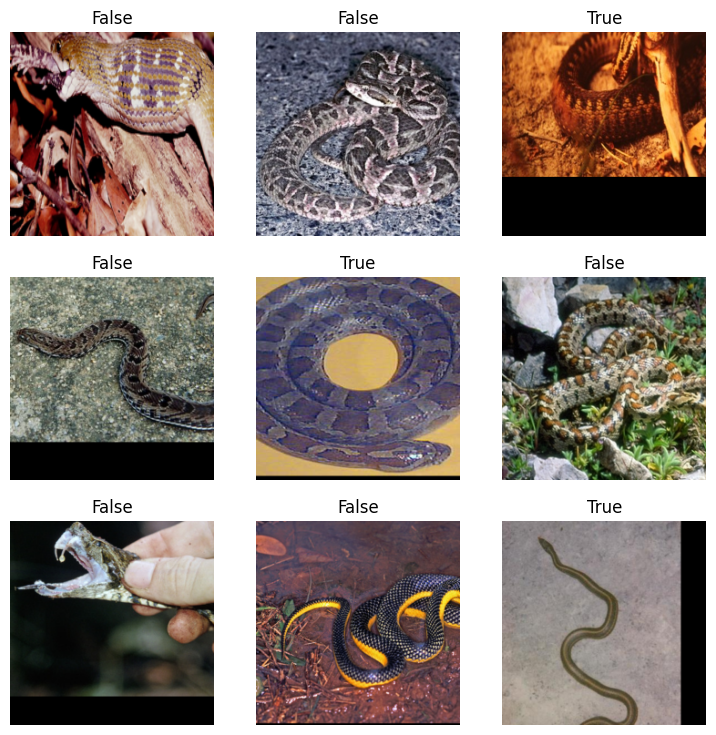

In [4]:
def get_transforms(*, size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Create basic image transforms for training or validation dataset."""
    train_tfms = T.Compose([
        T.RandomResizedCrop((size, size), scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomApply(torch.nn.ModuleList([
            T.ColorJitter(brightness=0.2, contrast=0.2)
        ]), p=0.2),  # random brightness contrast
        T.ToTensor(),
        T.Normalize(mean, std)])
    valid_tfms = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean, std)])
    return train_tfms, valid_tfms

train_tfms, valid_tfms = get_transforms(
    size=config.input_size, mean=config.image_mean,
    std=config.image_std)

# create data loaders
trainloader = data.get_dataloader(
    train_df[:100], img_path_col='image_path', label_col='endemic',
    path=DATA_DIR , bbox=True, transforms=train_tfms, labels=classes, 
    batch_size=config.batch_size, sampler='weighted', num_workers=4)
validloader = data.get_dataloader(
    train_df[:100], img_path_col='image_path', label_col='endemic',
    path=DATA_DIR , bbox=True, transforms=valid_tfms, labels=classes,
    batch_size=config.batch_size, sampler='weighted', num_workers=4)

trainloader.dataset.show_items()

In [5]:
# create loss

criterion = loss_fn(weights = True) 

# create trainer
trainer = training.Trainer(
    model,
    trainloader,
    criterion,
    opt_fn,
    sched_fn,
    validloader=validloader,
    accumulation_steps=config.total_batch_size // config.batch_size,
    path='.',
    model_filename=config.model_name,
    history_filename=config.history_file,
    device=device)

In [6]:
'''
IGNORE SNAKE SCORE HERE

'''
trainer.train(no_epochs=config.no_epochs, lr=config.learning_rate)

epoch,train_loss,valid_loss,accuracy,snake_score,f1_score,time
0,1.757002,1.733453,0.530000,94,0.524243,01:26
1,1.593215,1.683556,0.630000,74,0.625468,01:31


Epoch 1 - Save Checkpoint with Best F1 Score: 0.524243
Epoch 2 - Save Checkpoint with Best F1 Score: 0.625468


KeyboardInterrupt: 